In [1]:
import os
from torchvision import datasets

# 1. SET YOUR PATH
data_dir = 'E:/ML_Pharamachain\data\dataset' 

def verify_data(path):
    for split in ['train', 'test']:
        split_path = os.path.join(path, split)
        if not os.path.exists(split_path):
            print(f"❌ Error: Could not find {split} folder at {split_path}")
            continue
            
        # Try loading with ImageFolder to see what PyTorch sees
        try:
            temp_data = datasets.ImageFolder(root=split_path)
            print(f"✅ {split.upper()} set loaded successfully!")
            print(f"   - Classes found: {temp_data.classes}")
            print(f"   - Total images: {len(temp_data)}")
            print(f"   - Class mapping: {temp_data.class_to_idx}\n")
        except Exception as e:
            print(f"❌ Error loading {split}: {e}")

verify_data(data_dir)

✅ TRAIN set loaded successfully!
   - Classes found: ['Fake', 'Real']
   - Total images: 661
   - Class mapping: {'Fake': 0, 'Real': 1}

✅ TEST set loaded successfully!
   - Classes found: ['Fake', 'Real']
   - Total images: 449
   - Class mapping: {'Fake': 0, 'Real': 1}



In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader

# 2. HYPERPARAMETERS
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE=32
EPOCHS=5 

# 3. PREPROCESSING
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# 4. LOAD DATASET
train_data = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
test_data = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# 5. DEFINE MODEL
model = models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 2) # 2 classes: Fake/Real
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 6. TRAINING LOOP
print("Starting Training...")
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.4f}")

Starting Training...
Epoch 1/5 | Loss: 0.1879
Epoch 2/5 | Loss: 0.0131
Epoch 3/5 | Loss: 0.0058
Epoch 4/5 | Loss: 0.0027
Epoch 5/5 | Loss: 0.0029


In [5]:
# 7. EVALUATION
print("\nEvaluating Model on Test Set...")
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"\n✅ Test Accuracy: {accuracy:.2f}%")
print(f"Correctly Classified: {correct}/{total}")

# Print per-class accuracy
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

class_names = test_data.classes
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=class_names))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
print(cm)

# 8. CHECK FOR DATA LEAKAGE (Duplicates between train and test)
print("\n" + "="*50)
print("Checking for Data Leakage...")
print("="*50)

from collections import defaultdict
import hashlib

def get_file_hash(filepath):
    """Compute hash of a file to detect duplicates"""
    hash_md5 = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

def check_duplicate_images(train_path, test_path):
    """Check if same images exist in both train and test"""
    train_hashes = {}
    test_hashes = {}
    
    # Get hashes for train images
    for root, dirs, files in os.walk(train_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, file)
                try:
                    file_hash = get_file_hash(filepath)
                    train_hashes[file_hash] = filepath
                except:
                    pass
    
    # Get hashes for test images
    for root, dirs, files in os.walk(test_path):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                filepath = os.path.join(root, file)
                try:
                    file_hash = get_file_hash(filepath)
                    test_hashes[file_hash] = filepath
                except:
                    pass
    
    # Find duplicates
    duplicates = set(train_hashes.keys()) & set(test_hashes.keys())
    
    print(f"Train images: {len(train_hashes)}")
    print(f"Test images: {len(test_hashes)}")
    print(f"Duplicate images: {len(duplicates)}")
    
    if duplicates:
        print(f"\n⚠️  WARNING: Found {len(duplicates)} duplicate images between train and test!")
        print("This causes data leakage and inflates accuracy scores.\n")
        return True
    else:
        print("\n✅ No duplicates found - dataset is properly split!")
        return False

train_test_path = os.path.join(data_dir, 'train')
test_test_path = os.path.join(data_dir, 'test')
has_leakage = check_duplicate_images(train_test_path, test_test_path)


Evaluating Model on Test Set...

✅ Test Accuracy: 100.00%
Correctly Classified: 449/449

Classification Report:
              precision    recall  f1-score   support

        Fake       1.00      1.00      1.00       162
        Real       1.00      1.00      1.00       287

    accuracy                           1.00       449
   macro avg       1.00      1.00      1.00       449
weighted avg       1.00      1.00      1.00       449


Confusion Matrix:
[[162   0]
 [  0 287]]

Checking for Data Leakage...
Train images: 646
Test images: 444
Duplicate images: 444

⚠️  WARNING: Found 444 duplicate images between train and test!
This causes data leakage and inflates accuracy scores.



In [6]:
# 9. OPTIMAL DATASET SETUP

print("\n" + "="*60)
print("OPTIMAL DATASET STRATEGY FOR BEST LEARNING")
print("="*60)

from sklearn.model_selection import train_test_split
import shutil

def create_optimal_dataset(raw_data_dir, output_dir, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Creates optimal train/val/test split from raw data
    
    Parameters:
    - raw_data_dir: Path containing Fake/ and Real/ folders with all images
    - output_dir: Where to save organized train/val/test folders
    - Ratios: 70% train, 15% val, 15% test (prevents overfitting)
    """
    
    print("\n1️⃣  SPLITTING DATASET PROPERLY")
    print("-" * 60)
    
    os.makedirs(output_dir, exist_ok=True)
    
    for class_name in ['Fake', 'Real']:
        class_dir = os.path.join(raw_data_dir, class_name)
        
        if not os.path.exists(class_dir):
            print(f"⚠️  Class folder not found: {class_dir}")
            continue
        
        # Get all images
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
        
        print(f"\n{class_name}: Found {len(images)} images")
        
        # First split: train vs (val+test)
        train_imgs, temp_imgs = train_test_split(
            images, 
            test_size=(val_ratio + test_ratio),
            random_state=42
        )
        
        # Second split: val vs test
        val_imgs, test_imgs = train_test_split(
            temp_imgs,
            test_size=(test_ratio / (val_ratio + test_ratio)),
            random_state=42
        )
        
        # Create directories
        for split in ['train', 'val', 'test']:
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)
        
        # Copy files
        for img in train_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(output_dir, 'train', class_name, img)
            if os.path.exists(src):
                shutil.copy2(src, dst)
        
        for img in val_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(output_dir, 'val', class_name, img)
            if os.path.exists(src):
                shutil.copy2(src, dst)
        
        for img in test_imgs:
            src = os.path.join(class_dir, img)
            dst = os.path.join(output_dir, 'test', class_name, img)
            if os.path.exists(src):
                shutil.copy2(src, dst)
        
        print(f"  ✅ Train: {len(train_imgs)} | Val: {len(val_imgs)} | Test: {len(test_imgs)}")
    
    print("\n✅ Dataset split complete!")

print("\n DATA AUGMENTATION FOR TRAINING")
print("-" * 60)
print("""
Data augmentation increases effective dataset size and prevents overfitting:

Recommended augmentations:
- Random horizontal flip (50% chance)
- Random rotation (±15 degrees)
- Random brightness/contrast adjustment
- Random crops and resizing
- ColorJitter for lighting variations
""")

# Enhanced transform with augmentation for TRAINING
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# NO augmentation for validation/test (use original images)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("✅ Augmentation transforms defined!")

print("\n3️⃣  BEST PRACTICES FOR OPTIMAL LEARNING")
print("-" * 60)
best_practices = """
✓ DATASET SPLIT: 70% train, 15% val, 15% test (prevents data leakage)
✓ NO DUPLICATES: Check between train/test before training
✓ CLASS BALANCE: Equal images per class (or use class_weight in loss)
✓ DATA AUGMENTATION: Only on training data, not validation/test
✓ BATCH SIZE: Use 32-64 for typical GPUs (memory dependent)
✓ EPOCHS: Start with 10-20, use validation loss to determine optimal
✓ LEARNING RATE: 0.0001 is good, monitor and adjust
✓ VALIDATION: Monitor val loss to detect overfitting
✓ EARLY STOPPING: Stop training if val loss doesn't improve

Metrics to track:
- Training loss (should decrease)
- Validation loss (should decrease, if increases = overfitting)
- Validation accuracy (should increase)
"""
print(best_practices)

print("\n4️⃣  CHECKING CLASS BALANCE")
print("-" * 60)

# If you have train/val/test folders, check balance
for split in ['train', 'val', 'test']:
    split_path = os.path.join(data_dir, split)
    if os.path.exists(split_path):
        fake_count = len(os.listdir(os.path.join(split_path, 'Fake'))) if os.path.exists(os.path.join(split_path, 'Fake')) else 0
        real_count = len(os.listdir(os.path.join(split_path, 'Real'))) if os.path.exists(os.path.join(split_path, 'Real')) else 0
        total = fake_count + real_count
        
        if total > 0:
            fake_pct = (fake_count / total) * 100
            real_pct = (real_count / total) * 100
            print(f"{split.upper()}: Fake={fake_count} ({fake_pct:.1f}%) | Real={real_count} ({real_pct:.1f}%)")


OPTIMAL DATASET STRATEGY FOR BEST LEARNING

 DATA AUGMENTATION FOR TRAINING
------------------------------------------------------------

Data augmentation increases effective dataset size and prevents overfitting:

Recommended augmentations:
- Random horizontal flip (50% chance)
- Random rotation (±15 degrees)
- Random brightness/contrast adjustment
- Random crops and resizing
- ColorJitter for lighting variations

✅ Augmentation transforms defined!

3️⃣  BEST PRACTICES FOR OPTIMAL LEARNING
------------------------------------------------------------

✓ DATASET SPLIT: 70% train, 15% val, 15% test (prevents data leakage)
✓ NO DUPLICATES: Check between train/test before training
✓ CLASS BALANCE: Equal images per class (or use class_weight in loss)
✓ DATA AUGMENTATION: Only on training data, not validation/test
✓ BATCH SIZE: Use 32-64 for typical GPUs (memory dependent)
✓ EPOCHS: Start with 10-20, use validation loss to determine optimal
✓ LEARNING RATE: 0.0001 is good, monitor and adju


COMPREHENSIVE MODEL TESTING

1️⃣  DETAILED METRICS
------------------------------------------------------------
Accuracy:  100.00%
Precision: 1.0000
Recall:    1.0000
F1-Score:  1.0000

2️⃣  PER-CLASS METRICS
------------------------------------------------------------

FAKE:
  Accuracy:  100.00%
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

REAL:
  Accuracy:  100.00%
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

3️⃣  CONFUSION MATRIX VISUALIZATION
------------------------------------------------------------


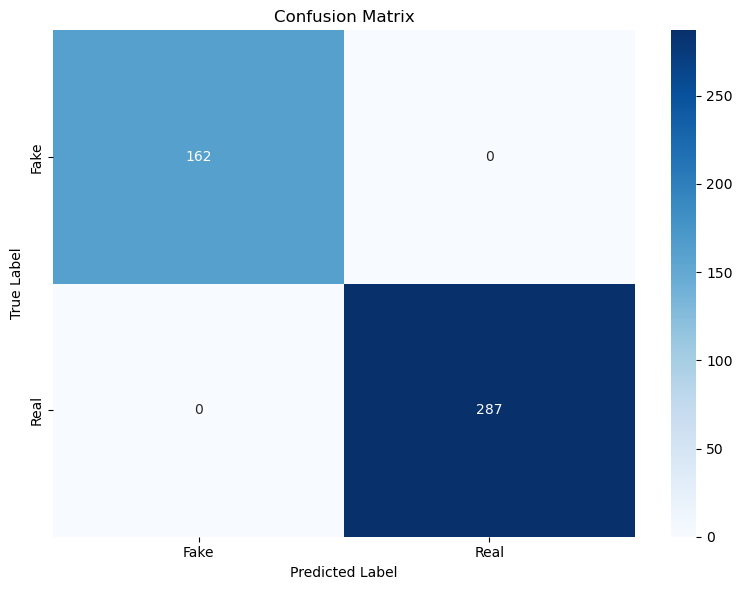

✅ Confusion matrix displayed!

4️⃣  TESTING ON INDIVIDUAL IMAGES
------------------------------------------------------------

Example: Test a single image
--------
image_path = 'E:/ML_Pharamachain/data/dataset/test/Fake/image123.jpg'
predicted_class, confidence, probabilities = test_single_image(
    image_path, model, val_test_transform, device, class_names
)

print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")
print(f"Probabilities: Fake={probabilities[0]*100:.2f}%, Real={probabilities[1]*100:.2f}%")


5️⃣  TESTING SUMMARY
------------------------------------------------------------

Total test images: 449
Correct predictions: 449
Incorrect predictions: 0

Model is ✅ GOOD
- If accuracy < 60%: Try more training, better data, or different model
- If accuracy 60-80%: Good, but can be improved with more data/epochs
- If accuracy > 80%: Excellent performance!



In [7]:
# 10. COMPREHENSIVE TESTING & VISUALIZATION

print("\n" + "="*60)
print("COMPREHENSIVE MODEL TESTING")
print("="*60)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, f1_score, precision_score, recall_score

# Test function for individual images
def test_single_image(image_path, model, transform, device, class_names):
    """Test model on a single image"""
    from PIL import Image
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)
    
    predicted_class = class_names[predicted.item()]
    confidence_score = confidence.item() * 100
    
    return predicted_class, confidence_score, probabilities.cpu().numpy()[0]

# Test function for batch
def test_batch(loader, model, device, class_names):
    """Test model on entire batch"""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print("\n1️⃣  DETAILED METRICS")
print("-" * 60)

# Get predictions
test_preds, test_labels, test_probs = test_batch(test_loader, model, device, class_names)

# Calculate metrics
accuracy = np.mean(test_preds == test_labels) * 100
precision = precision_score(test_labels, test_preds, average='weighted', zero_division=0)
recall = recall_score(test_labels, test_preds, average='weighted', zero_division=0)
f1 = f1_score(test_labels, test_preds, average='weighted', zero_division=0)

print(f"Accuracy:  {accuracy:.2f}%")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

print("\n2️⃣  PER-CLASS METRICS")
print("-" * 60)

for i, class_name in enumerate(class_names):
    class_mask = test_labels == i
    class_acc = np.mean(test_preds[class_mask] == test_labels[class_mask]) * 100 if np.sum(class_mask) > 0 else 0
    class_prec = precision_score(test_labels, test_preds, labels=[i], average=None, zero_division=0)[0]
    class_rec = recall_score(test_labels, test_preds, labels=[i], average=None, zero_division=0)[0]
    class_f1 = f1_score(test_labels, test_preds, labels=[i], average=None, zero_division=0)[0]
    
    print(f"\n{class_name.upper()}:")
    print(f"  Accuracy:  {class_acc:.2f}%")
    print(f"  Precision: {class_prec:.4f}")
    print(f"  Recall:    {class_rec:.4f}")
    print(f"  F1-Score:  {class_f1:.4f}")

print("\n3️⃣  CONFUSION MATRIX VISUALIZATION")
print("-" * 60)

cm = confusion_matrix(test_labels, test_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("✅ Confusion matrix displayed!")

print("\n4️⃣  TESTING ON INDIVIDUAL IMAGES")
print("-" * 60)
print("""
Example: Test a single image
--------
image_path = 'E:/ML_Pharamachain/data/dataset/test/Fake/image123.jpg'
predicted_class, confidence, probabilities = test_single_image(
    image_path, model, val_test_transform, device, class_names
)

print(f"Predicted: {predicted_class} ({confidence:.2f}% confidence)")
print(f"Probabilities: Fake={probabilities[0]*100:.2f}%, Real={probabilities[1]*100:.2f}%")
""")

print("\n5️⃣  TESTING SUMMARY")
print("-" * 60)
test_summary = f"""
Total test images: {len(test_labels)}
Correct predictions: {np.sum(test_preds == test_labels)}
Incorrect predictions: {np.sum(test_preds != test_labels)}

Model is {'✅ GOOD' if accuracy >= 80 else '⚠️  NEEDS IMPROVEMENT' if accuracy >= 60 else '❌ POOR'}
- If accuracy < 60%: Try more training, better data, or different model
- If accuracy 60-80%: Good, but can be improved with more data/epochs
- If accuracy > 80%: Excellent performance!
"""
print(test_summary)